In [ ]:
import os
import cv2
import h5py
import numpy
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
# from keras.layers.advanced_activations import PReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt
import math

DATA_PATH = "/content/drive/MyDrive/MyColab/finaldataset/train/"
TEST_PATH = "/content/drive/MyDrive/MyColab/finaldataset/test/"
Random_Crop = 30
Patch_size = 32
label_size = 20
conv_side = 6
scale = 2
# BORDER_CUT = 8
BLOCK_STEP = 16
BLOCK_SIZE = 32

In [ ]:
# mounting google cloud

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#unrar path
rarPath = '/content/drive/MyDrive/MyColab'
!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive(f'{rarPath}/archive.zip').extractall(rarPath)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#spliting data train and val

import os
from random import choice
import shutil

#arrays to store file names
imgs =[]

#setup dir names
imagePath = '/content/drive/MyDrive/MyColab/finaldataset_devops4' # dir where the splitted images is going to be stored
crsPath = '/content/drive/MyDrive/MyColab/images/images/' #dir where the original images stored

#setup ratio (val ratio = rest of the files in origin dir after splitting into train and test)
train_ratio = 0.8
test_ratio = 0.2

# path for specific paths
trainimagePath = f'{imagePath}/train'
testimagePath = f'{imagePath}/test'

#total count of imgs
totalImgCount = len(os.listdir(crsPath))/2

#make dir
def make_folder(path="output"):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

trainimagePath = make_folder(trainimagePath)
testimagePath = make_folder(testimagePath)

In [ ]:
print(trainimagePath)

/content/drive/MyDrive/MyColab/finaldataset_devops4/train


In [ ]:
i = 0
crsPath = '/content/drive/MyDrive/MyColab/images/images/'
for (_, _, files) in os.walk(crsPath):
  if i > 20:
    break
  else:
    i= i+1


In [ ]:
i = 0
crsPath = '/content/drive/MyDrive/MyColab/images/images/'
for (dirname, dirs, files) in os.walk(crsPath):
    for filename in files:
            if i > 20:
              break
            else:
              i = i+1  
              print(filename)


image_2188.jpg
image_219.jpg
image_2190.jpg
image_2191.jpg
image_2193.jpg
image_2195.jpg
image_2196.jpg
image_2197.jpg
image_2198.jpg
image_2199.jpg
image_220.jpg
image_2201.jpg
image_2202.jpg
image_2203.jpg
image_2204.jpg
image_2207.jpg
image_2208.jpg
image_2209.jpg
image_2211.jpg
image_2213.jpg
image_2214.jpg


In [ ]:
#soring files to corresponding arrays
i = 0
for (dirname, dirs, files) in os.walk(crsPath):
    for filename in files:
      # imgs.append(filename)
            if i > 300:
              break
            else:
              i = i+1  
              imgs.append(filename)


#counting range for cycles
countForTrain = int(len(imgs)*train_ratio)
countFortest = int(len(imgs)*test_ratio)
print("training images are : ",countForTrain)
print("test images are : ",countFortest)

#cycle for train dir
for x in range(countForTrain):

    fileJpg = choice(imgs) # get name of random image from origin dir
    shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(trainimagePath, fileJpg))

      #remove files from arrays
    imgs.remove(fileJpg)



#cycle for test dir   
for x in range(countFortest):

    fileJpg = choice(imgs) # get name of random image from origin dir
    shutil.copy(os.path.join(crsPath, fileJpg), os.path.join(testimagePath, fileJpg))
      
      #remove files from arrays
    imgs.remove(fileJpg)
    
#rest of files will be validation files, so rename origin dir to val dir
#os.rename(crsPath, valPath)

training images are :  240
test images are :  60


In [ ]:
print(1643 + 410)

2053


In [ ]:
def prepare_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = numpy.zeros((nums * Random_Crop, 1, Patch_size, Patch_size), dtype=numpy.double)
    label = numpy.zeros((nums * Random_Crop, 1, label_size, label_size), dtype=numpy.double)

    for i in range(nums):
        name = _path + names[i]
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        shape = hr_img.shape

        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(shape[0] / scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        # produce Random_Crop random coordinate to crop training img
        Points_x = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)
        Points_y = numpy.random.randint(0, min(shape[0], shape[1]) - Patch_size, Random_Crop)

        for j in range(Random_Crop):
            lr_patch = lr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]
            hr_patch = hr_img[Points_x[j]: Points_x[j] + Patch_size, Points_y[j]: Points_y[j] + Patch_size]

            lr_patch = lr_patch.astype(float) / 255.
            hr_patch = hr_patch.astype(float) / 255.

            data[i * Random_Crop + j, 0, :, :] = lr_patch
            label[i * Random_Crop + j, 0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]
            # cv2.imshow("lr", lr_patch)
            # cv2.imshow("hr", hr_patch)
            # cv2.waitKey(0)
    return data, label

In [ ]:
def prepare_crop_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        print(name)
        hr_img = cv2.imread(name, cv2.IMREAD_COLOR)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
        hr_img = hr_img[:, :, 0]
        shape = hr_img.shape

        # two resize operation to produce training data and labels
        lr_img = cv2.resize(hr_img, (int(shape[1] / scale), int(shape[0] / scale)))
        lr_img = cv2.resize(lr_img, (shape[1], shape[0]))

        width_num = int((shape[0] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        height_num = int((shape[1] - (BLOCK_SIZE - BLOCK_STEP) * 2) / BLOCK_STEP)
        for k in range(width_num):
            for j in range(height_num):
                x = k * BLOCK_STEP
                y = j * BLOCK_STEP
                hr_patch = hr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]
                lr_patch = lr_img[x: x + BLOCK_SIZE, y: y + BLOCK_SIZE]

                lr_patch = lr_patch.astype(float) / 255.
                hr_patch = hr_patch.astype(float) / 255.

                lr = numpy.zeros((1, Patch_size, Patch_size), dtype=numpy.double)
                hr = numpy.zeros((1, label_size, label_size), dtype=numpy.double)

                lr[0, :, :] = lr_patch
                hr[0, :, :] = hr_patch[conv_side: -conv_side, conv_side: -conv_side]

                data.append(lr)
                label.append(hr)

    data = numpy.array(data, dtype=float)
    label = numpy.array(label, dtype=float)
    return data, label

In [ ]:
def write_hdf5(data, labels, output_filename):
    """
    This function is used to save image data and its label(s) to hdf5 file.
    output_file.h5,contain data and label
    """

    x = data.astype(numpy.float32)
    y = labels.astype(numpy.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        # h.create_dataset()


In [ ]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        train_data = numpy.transpose(data, (0, 2, 3, 1))
        train_label = numpy.transpose(label, (0, 2, 3, 1))
        return train_data, train_label

In [ ]:
################### performing preparation for training and testing dataset######################################
trainz = "/content/drive/MyDrive/MyColab/finaldataset_devops4/train/"
testz = "/content/drive/MyDrive/MyColab/finaldataset_devops4/test/"
data, label = prepare_crop_data(trainz)
write_hdf5(data, label, "/content/drive/MyDrive/MyColab/train4.h5")
data, label = prepare_data(testz)
write_hdf5(data, label, "/content/drive/MyDrive/MyColab/test4.h5")

/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2188.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_219.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2190.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2191.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2195.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2196.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2197.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2198.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2199.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_220.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2201.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2202.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/train/image_2203.jpg
/content/drive/MyDrive/MyColab/finaldataset_devops4/t

In [ ]:
################# SRCNN #################################### 

In [ ]:
def psnr(target, ref):
    # assume RGB image
    target_data = numpy.array(target, dtype=float)
    ref_data = numpy.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(numpy.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)


In [ ]:
# prelu
def model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform', padding='valid', use_bias=True, input_shape=(32, 32, 1)))
    SRCNN.add(PReLU())
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=True))
    SRCNN.add(PReLU())
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform', padding='valid', use_bias=True))
    SRCNN.add(PReLU())
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    return SRCNN

In [ ]:
#relu
def model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(32, 32, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(1,1), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    return SRCNN

In [ ]:
# relu
def predict_model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=64, kernel_size=(1,1), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    return SRCNN


In [ ]:
# prelu
def predict_model():
    # lrelu = LeakyReLU(alpha=0.1)
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(PReLU())
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform', padding='same', use_bias=True))
    SRCNN.add(PReLU())
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',padding='valid', use_bias=True))
    SRCNN.add(PReLU())
    adam = Adam(lr=0.0003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    return SRCNN

In [ ]:
def train():
    srcnn_model = model()
    print(srcnn_model.summary())
    data, label = read_training_data("/content/drive/MyDrive/MyColab/crop_train2.h5")
    val_data, val_label = read_training_data("/content/drive/MyDrive/MyColab/test2.h5")

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/MyColab/SRCNN_check3.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    train_history = srcnn_model.fit(data, label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, epochs=10, verbose=0)
    return train_history
    # srcnn_model.load_weights("m_model_adam.h5")


In [ ]:
def predict():
    srcnn_model = predict_model()
    srcnn_model.load_weights("/content/drive/MyDrive/MyColab/SRCNN_check3.h5")
    IMG_NAME = "/content/drive/MyDrive/MyColab/faces.jpeg"
    INPUT_NAME = "/content/drive/MyDrive/MyColab/inputF.jpg"
    OUTPUT_NAME = "/content/drive/MyDrive/MyColab/outputF.jpg"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    img[:, :, 0] = Y_img
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_NAME, img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = srcnn_model.predict(Y, batch_size=1) * 255.
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1 = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    im2 = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]
    im3 = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2YCrCb)[6: -6, 6: -6, 0]

    print ("bicubic:")
    print (cv2.PSNR(im1, im2))
    print ("bicubic:")
    print (cv2.PSNR(im1, im2))
    print ("SRCNN:")
    print (cv2.PSNR(im1, im3))

In [ ]:
######################## Train and Predict ##############################
history = train()
predict()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 24, 24, 128)       10496     
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)        204864    
                                                                 
 conv2d_18 (Conv2D)          (None, 24, 24, 64)        102464    
                                                                 
 conv2d_19 (Conv2D)          (None, 24, 24, 64)        102464    
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 64)        4160      
                                                                 
 conv2d_21 (Conv2D)          (None, 20, 20, 1)         1601      
                                                                 
Total params: 426,049
Trainable params: 426,049
Non-tr

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None

Epoch 1: val_loss improved from inf to 0.00260, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 2: val_loss improved from 0.00260 to 0.00247, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 3: val_loss improved from 0.00247 to 0.00242, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 4: val_loss improved from 0.00242 to 0.00239, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 5: val_loss improved from 0.00239 to 0.00236, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 6: val_loss improved from 0.00236 to 0.00235, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 7: val_loss did not improve from 0.00235

Epoch 8: val_loss did not improve from 0.00235

Epoch 9: val_loss improved from 0.00235 to 0.00233, saving model to /content/drive/MyDrive/MyColab/SRCNN_check3.h5

Epoch 10: val_loss improved from 0.00233 to 0.00232, saving model to /content/drive/MyDriv

ValueError: ignored

In [ ]:
predict()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


bicubic:
36.63356570402663
SRCNN:
38.73972635796805


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Accuracy Curves')

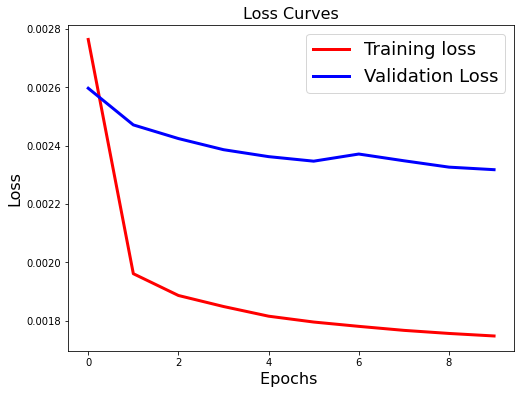

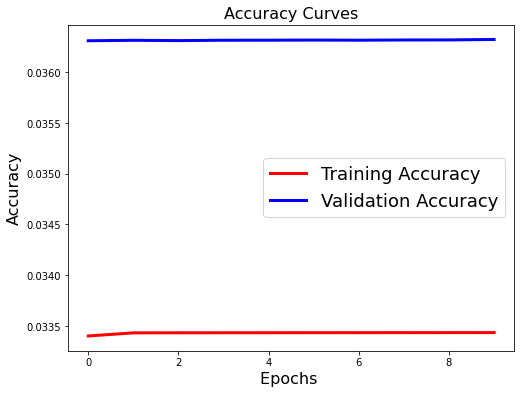

In [ ]:
print(history.history.keys())

#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)


#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history.history["accuracy"],'r',linewidth=3.0) 
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)